In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor

from warnings import filterwarnings

plt.rc('font', family = 'Malgun Gothic')
pd.set_option('display.max_columns', None)
filterwarnings('ignore')


# df = pd.read_csv('./dataset/sac_ver02.csv')
# df

## pivot table 만들기
- y = price  
   
- price max값 모델생성
  
- column = 남자 수, 여자 수, 비회원 수, 평균연령대, 장르, 장소, 러닝타임, 인터미션, 공연요일, 공연시간, 각 멤버십별 사람 수 column으로
  
- performance_code대신 performance_id를 생성함

In [4]:
def make_newdf(df, place = '콘서트홀'):
    new_df = df.query(f'`place` == "{place}"').sort_values(by = 'play')
    
    tmp = sorted(new_df.play.unique())

    for id, date in enumerate(tmp):
        idx = new_df.query(f'`play` == "{date}"').index
        new_df.loc[idx,'performance_id'] = id
    
    new_df.performance_id = new_df.performance_id.astype('int')
    new_df.drop('performance_code', axis = 1, inplace = True)
    
    df_0_100 = new_df.query('`discount_rate` in [0, 100]')
    df_1_99 = new_df.query('`discount_rate` not in [0, 100]')

    df_0_100.loc[:, 'price_org'] = df_0_100['price']
    df_1_99.loc[:, 'price_org'] = round(((100 / (100 - df_1_99['discount_rate'].astype(int))) * df_1_99['price'].astype(int)).astype(int), -4)

    new_df = pd.concat([df_0_100, df_1_99]).reset_index(drop = True)
            
    return new_df
    

In [18]:
def make_pivot(new_df):
    cols = ['gender_m','gender_f','member_n', 'age_10', 'age_20', 'age_30', 'age_40', 'age_50', 'age_60', 'age_70', 'age_80',
            'genre', 'place', 'running_time', 'intermission', 'play_day', 'play_time', 'member_normal', 'member_saesac', 
            'member_noble', 'member_free', 'member_green', 'member_blue', 'member_gold', 'price']

    pivot = pd.DataFrame(index = new_df.performance_id.unique(), columns = cols)
    
    pivot.loc[:,'intermission'] = new_df.groupby('performance_id')['intermission'].first().astype('int')
    pivot.loc[:,'running_time'] = new_df.groupby('performance_id')['running_time'].first().astype('int')
    pivot.loc[:,'genre'] = new_df.groupby('performance_id')['genre'].first()
    pivot.loc[:,'place'] = new_df.groupby('performance_id')['place'].first()
    pivot.loc[:,'play_day'] = new_df.groupby('performance_id')['play_day'].first()        
    pivot.loc[:, 'member_n'] = new_df.groupby('performance_id')['member_yn'].count() - new_df.groupby('performance_id')['member_yn'].sum()
    pivot.loc[:,'play_time'] = new_df.groupby('performance_id')['play'].first().str[11:13].astype('int')
    pivot.loc[:, 'price'] = new_df.groupby('performance_id')['price_org'].max()
    
    # left = pd.DataFrame(index = sorted(new_df['performance_id'].unique())).reset_index()
    # right = new_df.query('`age` != -1').groupby('performance_id')[['age']].mean().reset_index()
    # left.columns = ['performance_id']
    # m_age = pd.merge(left = left, right = right, how = 'outer', on = 'performance_id').fillna(-1).set_index('performance_id')
    # pivot.loc[:, 'age'] = m_age.age
    
    t = new_df.groupby(['performance_id', 'age'])[['gender']].count().reset_index()
    t = t.pivot_table(index = 'performance_id', columns = 'age', values = 'gender')
    
    t.columns = ['non', 'age_10', 'age_20', 'age_30', 'age_40', 'age_50', 'age_60', 'age_70', 'age_80']
    t = t.fillna(0).astype('int')[['age_10', 'age_20', 'age_30', 'age_40', 'age_50', 'age_60', 'age_70', 'age_80']]
    pivot.loc[:,['age_10', 'age_20', 'age_30', 'age_40', 'age_50', 'age_60', 'age_70', 'age_80']] = t
    
    
    t = new_df.groupby(['performance_id', 'membership_paid'])[['age']].count().reset_index()
    t = t.pivot_table(index = 'performance_id', columns = 'membership_paid', values = 'age',)

    t.columns = ['member_gold', 'member_green', 'member_free', 'member_blue', 'nonmember']
    t = t.fillna(0).astype('int')[['member_free', 'member_green', 'member_blue', 'member_gold']]
    pivot.loc[:,['member_free', 'member_green', 'member_blue', 'member_gold']] = t
    
    t = new_df.groupby(['performance_id', 'membership_free'])[['age']].count().reset_index()
    t = t.pivot_table(index = 'performance_id', columns = 'membership_free', values = 'age')
    
    t.columns = ['member_noble', 'nonmember', 'member_saesac', 'member_normal']
    t = t.fillna(0).astype('int')
    pivot.loc[:,['member_normal', 'member_saesac', 'member_noble']] = t
    
    t = new_df.groupby(['performance_id', 'gender'])[['age']].count().reset_index()
    t = t.pivot_table(index = 'performance_id', columns = ['gender'], values = 'age')
    t.columns = ['nonmember', 'gender_m', 'gender_f']
    t = t.fillna(0).astype('int')[['gender_m', 'gender_f']]
    pivot.loc[:,['gender_m', 'gender_f']] = t
    
    return pivot

### 함수 실행 및 csv파일 생성(이후 작업은 생선한 파일로 수행)

In [19]:
# ndf = make_newdf(df)
# pivot = make_pivot(ndf)
# pivot

# pivot.to_csv('./dataset/pivot_price.csv')

,gender_m,gender_f,member_n,age_10,age_20,age_30,age_40,age_50,age_60,age_70,age_80,genre,place,running_time,intermission,play_day,play_time,member_normal,member_saesac,member_noble,member_free,member_green,member_blue,member_gold,price
0,31,30,1757,0,5,4,10,14,14,10,4,클래식,콘서트홀,120,15,일요일,17,41,6,14,29,4,9,19,100000
1,40,21,2402,0,10,7,5,20,17,1,1,클래식,콘서트홀,140,20,토요일,17,46,13,2,28,3,3,27,100000
2,168,311,1441,2,38,49,98,122,101,48,21,합창,콘서트홀,120,15,화요일,20,348,62,69,215,25,75,164,100000
3,0,0,3007,0,0,0,0,0,0,0,0,콘서트,콘서트홀,100,20,목요일,20,0,0,0,0,0,0,0,0
4,0,0,2192,0,0,0,0,0,0,0,0,콘서트,콘서트홀,120,20,일요일,15,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,706,858,1257,10,237,310,326,400,220,55,6,교향곡,콘서트홀,120,15,일요일,17,1168,331,65,578,263,184,539,50000
747,659,1418,38,27,243,297,444,544,352,119,51,교향곡,콘서트홀,120,20,화요일,19,1592,315,170,421,395,246,1015,200000
748,312,761,103,12,154,237,295,220,100,30,25,독주,콘서트홀,100,20,수요일,19,830,188,55,244,219,155,455,130000
749,426,1549,1140,6,86,205,463,457,553,188,17,기타,콘서트홀,120,15,목요일,11,1666,104,205,812,164,270,729,30000


In [41]:
df = pd.read_csv('./dataset/pivot_price_ver02.csv', index_col = 0)
df

,gender_m,gender_f,member_n,age_10,age_20,age_30,age_40,age_50,age_60,age_70,age_80,genre,place,running_time,intermission,play_day,play_time,member_normal,member_saesac,member_noble,member_free,member_green,member_blue,member_gold,price
0,31,30,1757,0,5,4,10,14,14,10,4,클래식,콘서트홀,120,15,일요일,17,41,6,14,29,4,9,19,100000
1,40,21,2402,0,10,7,5,20,17,1,1,클래식,콘서트홀,140,20,토요일,17,46,13,2,28,3,3,27,100000
2,168,311,1441,2,38,49,98,122,101,48,21,합창,콘서트홀,120,15,화요일,20,348,62,69,215,25,75,164,100000
3,0,0,3007,0,0,0,0,0,0,0,0,콘서트,콘서트홀,100,20,목요일,20,0,0,0,0,0,0,0,0
4,0,0,2192,0,0,0,0,0,0,0,0,콘서트,콘서트홀,120,20,일요일,15,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,706,858,1257,10,237,310,326,400,220,55,6,교향곡,콘서트홀,120,15,일요일,17,1168,331,65,578,263,184,539,50000
747,659,1418,38,27,243,297,444,544,352,119,51,교향곡,콘서트홀,120,20,화요일,19,1592,315,170,421,395,246,1015,200000
748,312,761,103,12,154,237,295,220,100,30,25,독주,콘서트홀,100,20,수요일,19,830,188,55,244,219,155,455,130000
749,426,1549,1140,6,86,205,463,457,553,188,17,기타,콘서트홀,120,15,목요일,11,1666,104,205,812,164,270,729,30000


## 추가 labeling 및 파생변수 생성

In [42]:
genres = dict(zip(df.genre.unique(), range(df.genre.nunique())))
days = {'일요일' : 0, '화요일' : 1, '수요일' : 2, '목요일' : 3, '금요일' : 4, '토요일' : 5}


for idx in range(len(df)):
    df.loc[idx, 'genre'] = genres[df.loc[idx, 'genre']]
    df.loc[idx, 'play_day'] = days[df.loc[idx, 'play_day']]
    
    if df.loc[idx, 'play_time'] >= 18:
        df.loc[idx, 'play_timezone'] = 1
    else:
        df.loc[idx, 'play_timezone'] = 0
    
df.drop('place', axis = 1, inplace = True)
df.play_timezone = df.play_timezone.astype('int')
# df= pd.get_dummies(df, columns = ['genre', 'play_day'])*1
df

,gender_m,gender_f,member_n,age_10,age_20,age_30,age_40,age_50,age_60,age_70,age_80,genre,running_time,intermission,play_day,play_time,member_normal,member_saesac,member_noble,member_free,member_green,member_blue,member_gold,price,play_timezone
0,31,30,1757,0,5,4,10,14,14,10,4,0,120,15,0,17,41,6,14,29,4,9,19,100000,0
1,40,21,2402,0,10,7,5,20,17,1,1,0,140,20,5,17,46,13,2,28,3,3,27,100000,0
2,168,311,1441,2,38,49,98,122,101,48,21,1,120,15,1,20,348,62,69,215,25,75,164,100000,1
3,0,0,3007,0,0,0,0,0,0,0,0,2,100,20,3,20,0,0,0,0,0,0,0,0,1
4,0,0,2192,0,0,0,0,0,0,0,0,2,120,20,0,15,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,706,858,1257,10,237,310,326,400,220,55,6,4,120,15,0,17,1168,331,65,578,263,184,539,50000,0
747,659,1418,38,27,243,297,444,544,352,119,51,4,120,20,1,19,1592,315,170,421,395,246,1015,200000,1
748,312,761,103,12,154,237,295,220,100,30,25,8,100,20,2,19,830,188,55,244,219,155,455,130000,1
749,426,1549,1140,6,86,205,463,457,553,188,17,7,120,15,3,11,1666,104,205,812,164,270,729,30000,0


In [43]:
df['total_member'] = df['gender_m'] + df['gender_f'] + df['member_n']
genre = df.genre
df.drop(['member_normal', 'member_saesac', 'member_noble', 'play_time', 'genre', 'play_day' ], axis = 1, inplace = True)

df

,gender_m,gender_f,member_n,age_10,age_20,age_30,age_40,age_50,age_60,age_70,age_80,running_time,intermission,member_free,member_green,member_blue,member_gold,price,play_timezone,total_member
0,31,30,1757,0,5,4,10,14,14,10,4,120,15,29,4,9,19,100000,0,1818
1,40,21,2402,0,10,7,5,20,17,1,1,140,20,28,3,3,27,100000,0,2463
2,168,311,1441,2,38,49,98,122,101,48,21,120,15,215,25,75,164,100000,1,1920
3,0,0,3007,0,0,0,0,0,0,0,0,100,20,0,0,0,0,0,1,3007
4,0,0,2192,0,0,0,0,0,0,0,0,120,20,0,0,0,0,0,0,2192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,706,858,1257,10,237,310,326,400,220,55,6,120,15,578,263,184,539,50000,0,2821
747,659,1418,38,27,243,297,444,544,352,119,51,120,20,421,395,246,1015,200000,1,2115
748,312,761,103,12,154,237,295,220,100,30,25,100,20,244,219,155,455,130000,1,1176
749,426,1549,1140,6,86,205,463,457,553,188,17,120,15,812,164,270,729,30000,0,3115


## Clustering 시작

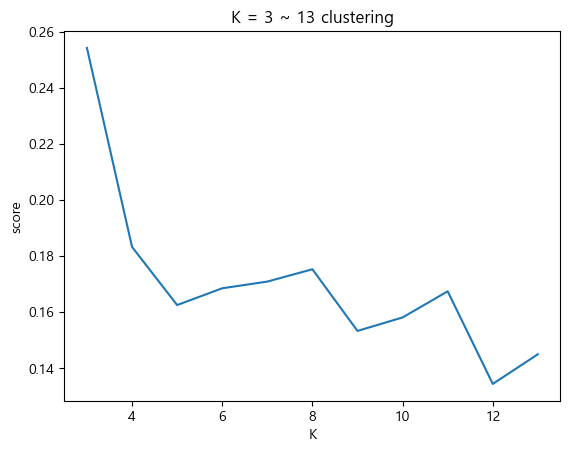

In [67]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

score_list = []
k_list = []
for k in range(3, 14):

    kmeans = KMeans(n_clusters = k)
    kmeans.fit(scaled_data)
    result = kmeans.labels_

    score_list.append(silhouette_score(scaled_data, result))
    k_list.append(k)
    

sns.lineplot(x = k_list, y = score_list)
plt.xlabel('K')
plt.ylabel('score')
plt.title('K = 3 ~ 13 clustering')
plt.show()


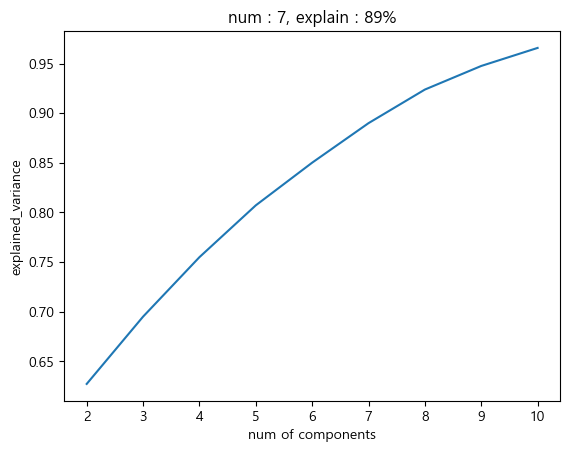

In [75]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

k_list = []
variance_ex = []
for k in range(2, 11):
    
    pca = PCA(n_components = k)
    pca.fit_transform(scaled_data)
    
    k_list.append(k)
    variance_ex.append(sum(pca.explained_variance_ratio_))
    
sns.lineplot(x = k_list, y = variance_ex)
plt.xlabel('num of components')
plt.ylabel('explained_variance')
plt.title('num : 7, explain : 89%')
plt.show()

In [76]:
pca = PCA(n_components = 7)
components = pca.fit_transform(scaled_data)

cols = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7']
pca_df = pd.DataFrame(data = components, columns = cols)

pca_df


,pc1,pc2,pc3,pc4,pc5,pc6,pc7
0,-2.871218,1.324906,0.016215,-0.314801,-0.989894,-0.917763,-0.581426
1,-2.982063,2.803987,0.048388,-1.117649,-1.183400,-0.323818,-0.484046
2,-0.599175,0.915035,1.388159,0.123112,0.158798,0.511181,-0.152714
3,-3.614669,3.001553,0.194411,1.058106,0.121252,0.463456,1.639133
4,-3.492008,2.051170,-0.354025,-0.227964,-1.674659,-0.221330,0.571898
...,...,...,...,...,...,...,...
746,4.472446,1.496617,-0.954621,0.599125,-1.895864,0.964889,0.323748
747,7.907164,0.451554,1.391362,-0.845102,0.827370,0.581169,0.321568
748,2.286049,-0.675454,-0.202307,-0.769339,1.149557,-0.068692,0.893793
749,6.684540,1.616671,2.279090,1.300450,-3.657445,0.855194,0.871300


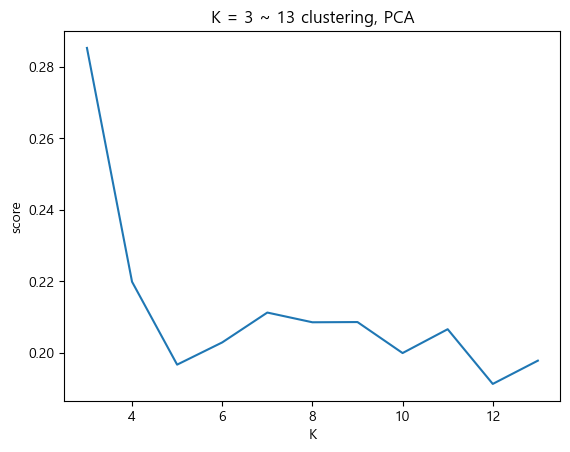

In [81]:
score_list = []
k_list = []
for k in range(3, 14):

    kmeans = KMeans(n_clusters = k)
    kmeans.fit(pca_df)
    result = kmeans.labels_

    score_list.append(silhouette_score(pca_df, result))
    k_list.append(k)
    

sns.lineplot(x = k_list, y = score_list)
plt.xlabel('K')
plt.ylabel('score')
plt.title('K = 3 ~ 13 clustering, PCA')
plt.show()

In [123]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

y = df.price
x = df.drop('price', axis = 1)

vif_list = []

for i in range(1, len(x.columns)):
    vif_list.append([vif(x.values, i), x.columns[i]])
    
pd.DataFrame(vif_list, columns = ['vif', 'variable'])

,vif,variable
0,inf,gender_f
1,inf,member_n
2,inf,age_10
3,inf,age_20
4,inf,age_30
5,inf,age_40
6,inf,age_50
7,inf,age_60
8,inf,age_70
9,inf,age_80


In [132]:
y = df.price
x = df.drop(['price','gender_f','gender_m', 'age_20','age_30','age_50', 'age_40', 'age_60','running_time', 'member_blue', 'member_gold', 'member_n'], axis = 1)

vif_list = []

for i in range(0, len(x.columns)):
    vif_list.append([vif(x.values, i), x.columns[i]])
    
pd.DataFrame(vif_list, columns = ['vif', 'variable'])

,vif,variable
0,2.147704,age_10
1,4.365951,age_70
2,2.272925,age_80
3,4.028590,intermission
4,4.570533,member_free
5,2.222741,member_green
6,2.461101,play_timezone
7,4.399260,total_member


In [142]:
from patsy import dmatrices

y, X = dmatrices('price ~ age_10 + age_70 + age_80 + intermission + member_free + member_green + play_timezone + total_member', data =df, return_type = 'dataframe')

X
                

,Intercept,age_10,age_70,age_80,intermission,member_free,member_green,play_timezone,total_member
0,1.0,0.0,10.0,4.0,15.0,29.0,4.0,0.0,1818.0
1,1.0,0.0,1.0,1.0,20.0,28.0,3.0,0.0,2463.0
2,1.0,2.0,48.0,21.0,15.0,215.0,25.0,1.0,1920.0
3,1.0,0.0,0.0,0.0,20.0,0.0,0.0,1.0,3007.0
4,1.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,2192.0
...,...,...,...,...,...,...,...,...,...
746,1.0,10.0,55.0,6.0,15.0,578.0,263.0,0.0,2821.0
747,1.0,27.0,119.0,51.0,20.0,421.0,395.0,1.0,2115.0
748,1.0,12.0,30.0,25.0,20.0,244.0,219.0,1.0,1176.0
749,1.0,6.0,188.0,17.0,15.0,812.0,164.0,0.0,3115.0


In [129]:
import time
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf

def processSubset(X,y, feature_set):
            model = sm.OLS(y,X[list(feature_set)]) # Modeling
            regr = model.fit() # 모델 학습
            AIC = regr.aic # 모델의 AIC
            return {"model":regr, "AIC":AIC}
# 전진선택법
def forward(X, y, predictors):
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    remaining_predictors = [p for p in X.columns.difference(['Intercept']) if p not in predictors]
    results = []
    for p in remaining_predictors:
        results.append(processSubset(X=X, y= y,            feature_set=predictors+[p]+['Intercept']))
        
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)
    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()] # index
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in")
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model

In [127]:
# 후진소거법
def backward(X,y,predictors):
    tic = time.time()
    results = []
    
    # 데이터 변수들이 미리정의된 predictors 조합 확인
    for combo in itertools.combinations(predictors, len(predictors) -1):
        results.append(processSubset(X=X, y= y,        feature_set = list(combo)+['Intercept']))
    models = pd.DataFrame(results)
    
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on",          len(predictors) -1, "predictors in", (toc - tic))
    print('Selected predictors:',best_model['model'].model.exog_names,         'AIC:',best_model[0] )

    return best_model

In [121]:
# 단계적 선택법
def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns=["AIC", "model"])
    tic = time.time()
    predictors = []
    Smodel_before = processSubset(X,y,predictors+['Intercept'])['AIC']

    for i in range(1, len(X.columns.difference(['Intercept'])) +1):
        Forward_result = forward(X=X, y=y, predictors=predictors) 
        print('forward')
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]["model"].model.exog_names
        predictors = [ k for k in predictors if k !='Intercept']
        Backward_result = backward(X=X, y=y, predictors=predictors)

        if Backward_result['AIC']< Forward_result['AIC']:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            Smodel_before = Stepmodels.loc[i]["AIC"]
            predictors = [ k for k in predictors if k !='Intercept']
            print('backward')

        if Stepmodels.loc[i]['AIC']> Smodel_before:
            break
        else:
            Smodel_before = Stepmodels.loc[i]["AIC"]
    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")

    return (Stepmodels['model'][len(Stepmodels['model'])])


In [144]:
stepwise_best_model = Stepwise_model(X= X, y = y)

Processed  8 models on 1 predictors in
Selected predictors: ['age_80', 'Intercept']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001FE9D6C2BF0>
forward
Processed  1 models on 0 predictors in 0.0019943714141845703
Selected predictors: ['Intercept'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001FE9D6C3520>
Processed  7 models on 2 predictors in
Selected predictors: ['age_80', 'member_green', 'Intercept']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001FE9D6C00D0>
forward
Processed  2 models on 1 predictors in 0.0019931793212890625
Selected predictors: ['age_80', 'Intercept'] AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001FE9D6C3880>
Processed  6 models on 3 predictors in
Selected predictors: ['age_80', 'member_green', 'intermission', 'Intercept']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000001FE9D6C

In [146]:
stepwise_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     50.92
Date:                Tue, 26 Sep 2023   Prob (F-statistic):           6.35e-38
Time:                        23:31:44   Log-Likelihood:                -9283.1
No. Observations:                 751   AIC:                         1.858e+04
Df Residuals:                     746   BIC:                         1.860e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
age_80         1383.2985    156.764      8.824      0.000    1075.548    1691.049
member_green     95.8098     12.536      7.643      0.000      71.200     120.420
intermission    965.6453    362.393      2.665      0.008     254.213    1677.077
play_timezone  9073.9422   4416.771      2.054      0.040     403.162    1.77e+04
Intercept      5.377e+04   6673.466      8.057      0.000    4.07e+04    6.69e+04
==============================================================================
Omnibus:                      212.953   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              992.135
Skew:                           1.219   Prob(JB):                    3.64e-216
Kurtosis:                       8.076   Cond. No.                         715.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

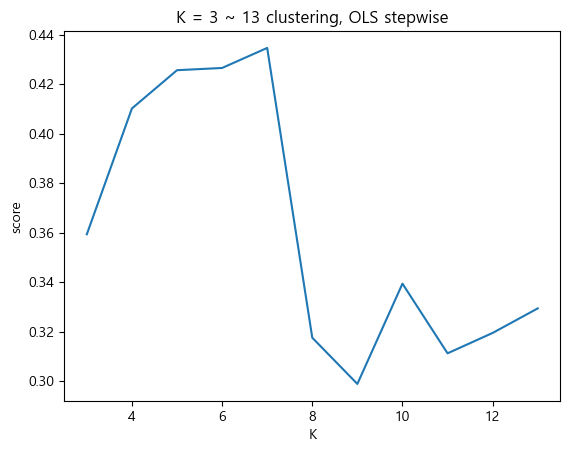

In [149]:

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['age_80', 'member_green', 'intermission', 'play_timezone', 'price']])

score_list = []
k_list = []
for k in range(3, 14):

    kmeans = KMeans(n_clusters = k)
    kmeans.fit(scaled_data)
    result = kmeans.labels_

    score_list.append(silhouette_score(scaled_data, result))
    k_list.append(k)
    

sns.lineplot(x = k_list, y = score_list)
plt.xlabel('K')
plt.ylabel('score')
plt.title('K = 3 ~ 13 clustering, OLS stepwise')
plt.show()

In [168]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['age_80', 'member_green', 'intermission', 'play_timezone', 'price']])

kmeans = KMeans(n_clusters = 7)
kmeans.fit(scaled_data)
result = kmeans.labels_

df['cluster'] = result

In [171]:
df.head(30)

,gender_m,gender_f,member_n,age_10,age_20,age_30,age_40,age_50,age_60,age_70,age_80,running_time,intermission,member_free,member_green,member_blue,member_gold,price,play_timezone,total_member,cluster,genre
0,31,30,1757,0,5,4,10,14,14,10,4,120,15,29,4,9,19,100000,0,1818,2,0
1,40,21,2402,0,10,7,5,20,17,1,1,140,20,28,3,3,27,100000,0,2463,2,0
2,168,311,1441,2,38,49,98,122,101,48,21,120,15,215,25,75,164,100000,1,1920,0,1
3,0,0,3007,0,0,0,0,0,0,0,0,100,20,0,0,0,0,0,1,3007,4,2
4,0,0,2192,0,0,0,0,0,0,0,0,120,20,0,0,0,0,0,0,2192,2,2
5,15,29,2154,0,3,2,7,14,7,8,3,120,15,21,2,7,14,100000,1,2198,0,3
6,411,711,695,6,75,200,245,271,239,74,12,105,15,427,94,176,425,140000,1,1817,0,0
7,154,388,551,2,180,67,103,103,51,30,6,120,20,255,39,83,165,150000,1,1093,0,3
8,179,395,202,17,28,92,152,161,73,45,6,100,15,310,59,63,142,100000,0,776,2,1
9,40,35,2104,0,10,9,10,18,13,13,2,120,20,29,5,14,27,150000,1,2179,0,0


In [172]:
# df.to_csv('./dataset/performance_cluster_ver02.csv')

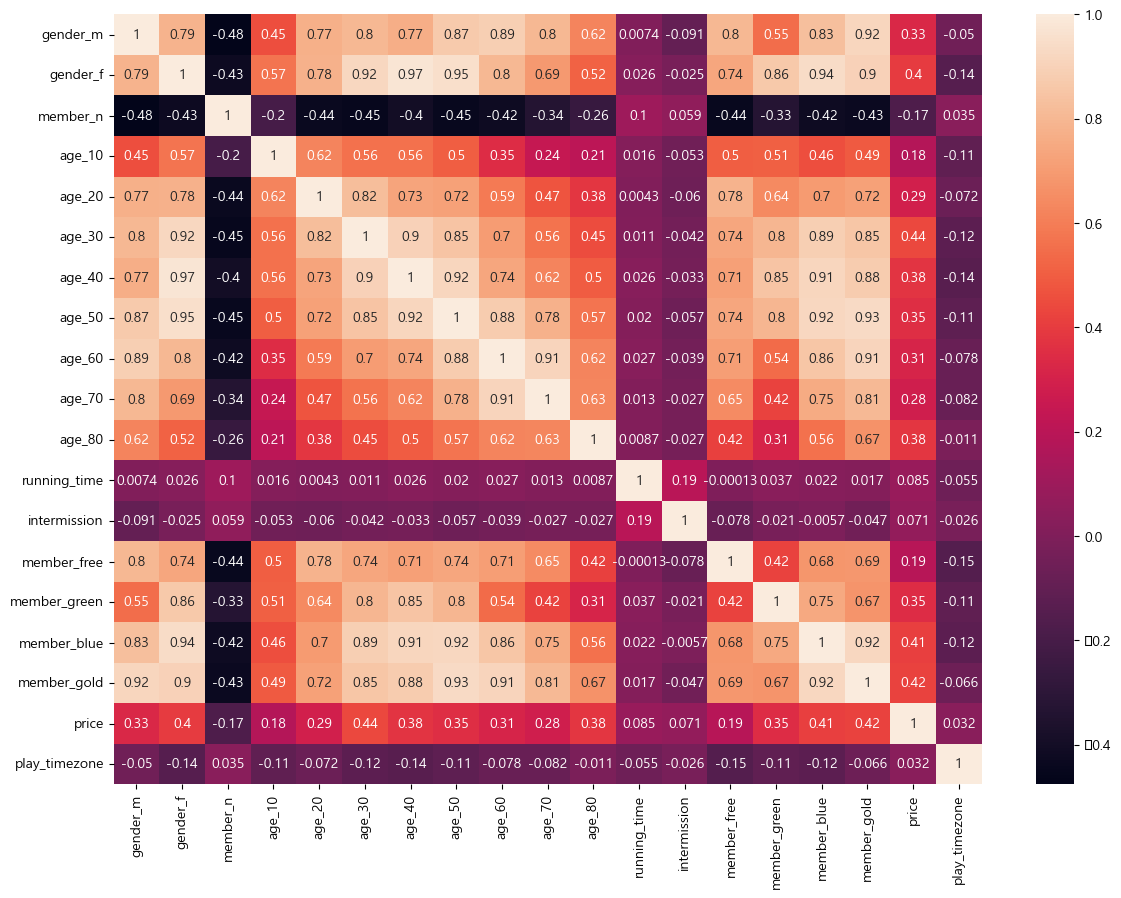

In [33]:
plt.figure(figsize = (14, 10))
sns.heatmap(df.iloc[:, :19].corr(), annot = True)
plt.show()

## 수치형 변수 scaling

In [35]:
cols = df.loc[:, ~df.columns.isin(['running_time', 'intermission', 'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9',
                                   'genre_10', 'genre_11', 'genre_12', 'play_day_0', 'play_day_1', 'play_day_2', 'play_day_3', 'play_day_4', 'play_day_5',
                                   'play_timezone', 'price'])].columns

df_scaling = pd.DataFrame(df.loc[:, ~df.columns.isin(['running_time', 'intermission', 'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9',
                                                    'genre_10', 'genre_11', 'genre_12', 'play_day_0', 'play_day_1', 'play_day_2', 'play_day_3', 'play_day_4', 'play_day_5',
                                                    'play_timezone', 'price'])].values / df.total_member.values.reshape((751,1)), columns = cols)
df_scaling.drop('total_member', axis = 1, inplace = True)

df3 = pd.concat([df_scaling, df.loc[:, ['running_time', 'intermission', 'genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9',
                                        'genre_10', 'genre_11', 'genre_12', 'play_day_0', 'play_day_1', 'play_day_2', 'play_day_3', 'play_day_4', 'play_day_5',
                                        'play_timezone', 'price']]], axis =1)

df3


,gender_m,gender_f,member_n,age_10,age_20,age_30,age_40,age_50,age_60,age_70,age_80,member_free,member_green,member_blue,member_gold,running_time,intermission,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10,genre_11,genre_12,play_day_0,play_day_1,play_day_2,play_day_3,play_day_4,play_day_5,play_timezone,price
0,0.017052,0.016502,0.966447,0.000000,0.002750,0.002200,0.005501,0.007701,0.007701,0.005501,0.002200,0.015952,0.002200,0.004950,0.010451,120,15,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,100000
1,0.016240,0.008526,0.975233,0.000000,0.004060,0.002842,0.002030,0.008120,0.006902,0.000406,0.000406,0.011368,0.001218,0.001218,0.010962,140,20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,100000
2,0.087500,0.161979,0.750521,0.001042,0.019792,0.025521,0.051042,0.063542,0.052604,0.025000,0.010937,0.111979,0.013021,0.039062,0.085417,120,15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,100000
3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100,20,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120,20,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,0.250266,0.304147,0.445587,0.003545,0.084013,0.109890,0.115562,0.141794,0.077987,0.019497,0.002127,0.204892,0.093229,0.065225,0.191067,120,15,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,50000
747,0.311584,0.670449,0.017967,0.012766,0.114894,0.140426,0.209929,0.257210,0.166430,0.056265,0.024113,0.199054,0.186761,0.116312,0.479905,120,20,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,200000
748,0.265306,0.647109,0.087585,0.010204,0.130952,0.201531,0.250850,0.187075,0.085034,0.025510,0.021259,0.207483,0.186224,0.131803,0.386905,100,20,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,130000
749,0.136758,0.497271,0.365971,0.001926,0.027608,0.065811,0.148636,0.146709,0.177528,0.060353,0.005457,0.260674,0.052648,0.086677,0.234029,120,15,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,30000


In [68]:
cols = df.loc[:, ~df.columns.isin(['genre', 'play_timezone', 'price'])].columns

df_scaling = pd.DataFrame(df.loc[:, ~df.columns.isin(['genre', 'play_timezone', 'price'])].values / df.total_member.values.reshape((751,1)), columns = cols)
df_scaling.drop('total_member', axis = 1, inplace = True)

df2 = pd.concat([df_scaling, df.loc[:, ['genre', 'play_timezone', 'price']]], axis =1)


In [71]:
df2

,gender_m,gender_f,member_n,age_10,age_20,age_30,age_40,age_50,age_60,age_70,age_80,member_free,member_green,member_blue,member_gold,genre,play_timezone,price
0,0.017052,0.016502,0.966447,0.000000,0.002750,0.002200,0.005501,0.007701,0.007701,0.005501,0.002200,0.015952,0.002200,0.004950,0.010451,0,0,100000
1,0.016240,0.008526,0.975233,0.000000,0.004060,0.002842,0.002030,0.008120,0.006902,0.000406,0.000406,0.011368,0.001218,0.001218,0.010962,0,0,100000
2,0.087500,0.161979,0.750521,0.001042,0.019792,0.025521,0.051042,0.063542,0.052604,0.025000,0.010937,0.111979,0.013021,0.039062,0.085417,1,1,100000
3,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,1,0
4,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,0.250266,0.304147,0.445587,0.003545,0.084013,0.109890,0.115562,0.141794,0.077987,0.019497,0.002127,0.204892,0.093229,0.065225,0.191067,4,0,50000
747,0.311584,0.670449,0.017967,0.012766,0.114894,0.140426,0.209929,0.257210,0.166430,0.056265,0.024113,0.199054,0.186761,0.116312,0.479905,4,1,200000
748,0.265306,0.647109,0.087585,0.010204,0.130952,0.201531,0.250850,0.187075,0.085034,0.025510,0.021259,0.207483,0.186224,0.131803,0.386905,8,1,130000
749,0.136758,0.497271,0.365971,0.001926,0.027608,0.065811,0.148636,0.146709,0.177528,0.060353,0.005457,0.260674,0.052648,0.086677,0.234029,7,0,30000


## 모델 테스트

In [36]:
def test_model(df):
    
    X = df.drop('price', axis = 1)
    y = df.price
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 22)

    parameters = {'n_estimators' : [20, 40, 60, 80],
                'max_depth' : [6, 10, 15, 20],
                'max_features' : [4, 7, 10]}
    model = RandomForestRegressor(random_state = 22, n_jobs = -1)

    grid = GridSearchCV(model, parameters, cv = 5, scoring = 'neg_mean_squared_log_error', verbose = 3, return_train_score = True)

    # scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_log_error')

    grid.fit(X_train, y_train)

    # print(f'rmsle 5 folds:', -scores)
    # print('mean :', np.mean(-scores))
    print('bestscore :', grid.best_score_)
    print('best params :', grid.best_params_)
    
    return X_train, X_test, y_train, y_test
    

In [37]:
X_train, X_test, y_train, y_test = test_model(df3)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END max_depth=6, max_features=4, n_estimators=20;, score=(train=-2.693, test=-5.454) total time=   0.0s
[CV 2/5] END max_depth=6, max_features=4, n_estimators=20;, score=(train=-1.988, test=-2.586) total time=   0.0s
[CV 3/5] END max_depth=6, max_features=4, n_estimators=20;, score=(train=-2.654, test=-2.799) total time=   0.0s
[CV 4/5] END max_depth=6, max_features=4, n_estimators=20;, score=(train=-2.647, test=-2.338) total time=   0.0s
[CV 5/5] END max_depth=6, max_features=4, n_estimators=20;, score=(train=-0.345, test=-1.210) total time=   0.0s
[CV 1/5] END max_depth=6, max_features=4, n_estimators=40;, score=(train=-3.064, test=-6.006) total time=   0.0s
[CV 2/5] END max_depth=6, max_features=4, n_estimators=40;, score=(train=-3.038, test=-4.086) total time=   0.0s
[CV 3/5] END max_depth=6, max_features=4, n_estimators=40;, score=(train=-3.057, test=-3.530) total time=   0.0s
[CV 4/5] END max_depth=6, max_feat

1.1210987673888895


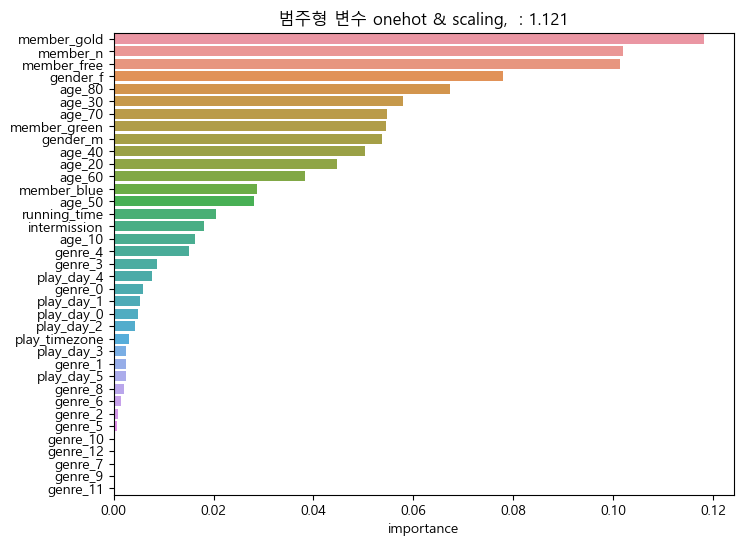

In [40]:
final = RandomForestRegressor(random_state = 22, max_depth = 20, max_features=10, n_estimators=20, n_jobs=-1)

final.fit(X_train, y_train)

pred = final.predict(X_test)

print(mean_squared_log_error(pred, y_test))

FI = pd.DataFrame(index = X_train.columns, columns = ['importance'])
FI.importance = final.feature_importances_

FI = FI.sort_values('importance', ascending= False)

plt.figure(figsize = (8, 6))
sns.barplot(y = FI.index, x = 'importance', data = FI)
plt.title(f'범주형 변수 onehot & scaling,  : {round(mean_squared_log_error(pred, y_test),3)}')
plt.show()  

In [69]:
X_train, X_test, y_train, y_test = test_model(df2)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END max_depth=6, max_features=4, n_estimators=20;, score=(train=-2.028, test=-4.451) total time=   0.0s
[CV 2/5] END max_depth=6, max_features=4, n_estimators=20;, score=(train=-2.397, test=-2.482) total time=   0.0s
[CV 3/5] END max_depth=6, max_features=4, n_estimators=20;, score=(train=-2.522, test=-1.947) total time=   0.0s
[CV 4/5] END max_depth=6, max_features=4, n_estimators=20;, score=(train=-2.552, test=-1.887) total time=   0.0s
[CV 5/5] END max_depth=6, max_features=4, n_estimators=20;, score=(train=-0.175, test=-1.184) total time=   0.0s
[CV 1/5] END max_depth=6, max_features=4, n_estimators=40;, score=(train=-2.030, test=-4.446) total time=   0.0s
[CV 2/5] END max_depth=6, max_features=4, n_estimators=40;, score=(train=-2.529, test=-3.343) total time=   0.0s
[CV 3/5] END max_depth=6, max_features=4, n_estimators=40;, score=(train=-3.017, test=-3.595) total time=   0.0s
[CV 4/5] END max_depth=6, max_feat

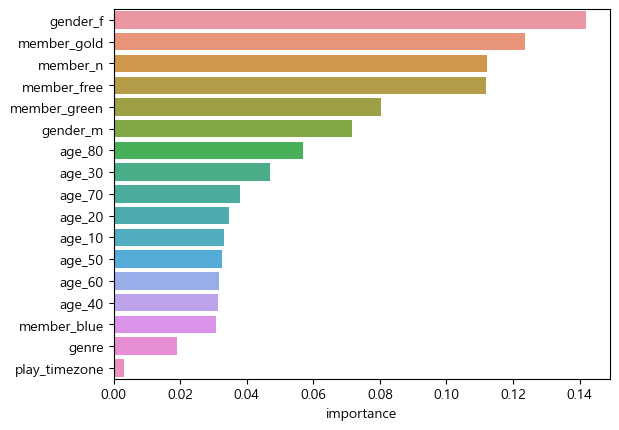

In [70]:
final = RandomForestRegressor(random_state = 22, max_depth = 15, max_features=10, n_estimators=20, n_jobs=-1)

final.fit(X_train, y_train)

pred = final.predict(X_test)

mean_squared_log_error(pred, y_test)

FI = pd.DataFrame(index = X_train.columns, columns = ['importance'])
FI.importance = final.feature_importances_

FI = FI.sort_values('importance', ascending= False)

sns.barplot(y = FI.index, x = 'importance', data = FI)
plt.show()  

In [37]:
X_train, X_test, y_train, y_test = test_model(df)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END max_depth=6, max_features=4, n_estimators=20;, score=(train=-1.071, test=-2.759) total time=   0.0s
[CV 2/5] END max_depth=6, max_features=4, n_estimators=20;, score=(train=-1.034, test=-3.366) total time=   0.0s
[CV 3/5] END max_depth=6, max_features=4, n_estimators=20;, score=(train=-1.888, test=-1.661) total time=   0.0s
[CV 4/5] END max_depth=6, max_features=4, n_estimators=20;, score=(train=-2.051, test=-2.371) total time=   0.0s
[CV 5/5] END max_depth=6, max_features=4, n_estimators=20;, score=(train=-0.188, test=-1.221) total time=   0.0s
[CV 1/5] END max_depth=6, max_features=4, n_estimators=40;, score=(train=-1.850, test=-3.626) total time=   0.0s
[CV 2/5] END max_depth=6, max_features=4, n_estimators=40;, score=(train=-1.369, test=-4.199) total time=   0.0s
[CV 3/5] END max_depth=6, max_features=4, n_estimators=40;, score=(train=-2.811, test=-2.762) total time=   0.0s
[CV 4/5] END max_depth=6, max_feat

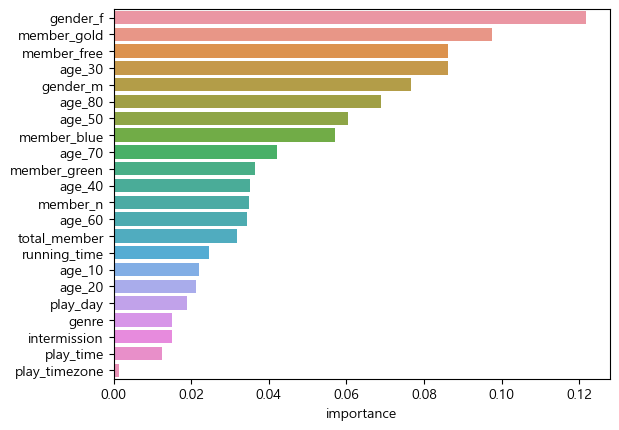

In [38]:
final = RandomForestRegressor(random_state = 22, max_depth = 15, max_features=10, n_estimators=20, n_jobs=-1)

final.fit(X_train, y_train)

pred = final.predict(X_test)

mean_squared_log_error(pred, y_test)

FI = pd.DataFrame(index = X_train.columns, columns = ['importance'])
FI.importance = final.feature_importances_

FI = FI.sort_values('importance', ascending= False)

sns.barplot(y = FI.index, x = 'importance', data = FI)
plt.show()  

In [25]:
X = df.drop('price', axis = 1)
y = df.price

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 22)

parameters = {'n_estimators' : [20, 40, 60, 80],
              'max_depth' : [6, 10, 15, 20],
              'max_features' : [4, 7, 10]}
model = RandomForestRegressor(random_state = 22, n_jobs = -1)

grid = GridSearchCV(model, parameters, cv = 5, scoring = 'neg_mean_squared_log_error', verbose = 3, return_train_score = True)

# scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_log_error')

grid.fit(X_train, y_train)

# print(f'rmsle 5 folds:', -scores)
# print('mean :', np.mean(-scores))
print('bestscore :', grid.best_score_)
print('best params :', grid.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END max_depth=6, max_features=4, n_estimators=20;, score=(train=-1.560, test=-3.700) total time=   0.0s
[CV 2/5] END max_depth=6, max_features=4, n_estimators=20;, score=(train=-0.865, test=-2.519) total time=   0.0s
[CV 3/5] END max_depth=6, max_features=4, n_estimators=20;, score=(train=-1.282, test=-1.522) total time=   0.0s
[CV 4/5] END max_depth=6, max_features=4, n_estimators=20;, score=(train=-1.671, test=-1.807) total time=   0.0s
[CV 5/5] END max_depth=6, max_features=4, n_estimators=20;, score=(train=-0.799, test=-3.098) total time=   0.0s
[CV 1/5] END max_depth=6, max_features=4, n_estimators=40;, score=(train=-2.259, test=-4.504) total time=   0.0s
[CV 2/5] END max_depth=6, max_features=4, n_estimators=40;, score=(train=-1.858, test=-3.523) total time=   0.0s
[CV 3/5] END max_depth=6, max_features=4, n_estimators=40;, score=(train=-1.706, test=-1.515) total time=   0.0s
[CV 4/5] END max_depth=6, max_feat

In [27]:
final = RandomForestRegressor(random_state = 22, max_depth = 15, max_features=7, n_estimators=20, n_jobs=-1)

final.fit(X_train, y_train)

pred = final.predict(X_test)

mean_squared_log_error(pred, y_test)

0.7621268658078393

In [28]:
FI = pd.DataFrame(index = X_train.columns, columns = ['importance'])
FI.importance = final.feature_importances_

FI = FI.sort_values('importance', ascending= False)

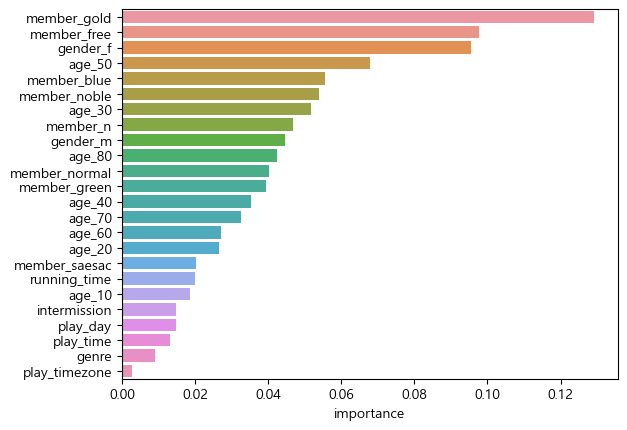

In [29]:
sns.barplot(y = FI.index, x = 'importance', data = FI)
plt.show()